In [1]:
import numpy as np 
import pandas as pd
import re 

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
import spacy

import nltk
from nltk.stem.snowball import SnowballStemmer

In [3]:
WORK_DIR = Path.cwd()
DATA_DIR = Path.cwd()/'data'

## Data Cleaning and Preprocessing

In [4]:
train = pd.read_csv(DATA_DIR/'raw/train.csv')
test = pd.read_csv(DATA_DIR/'raw/test.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train = train.fillna('missing')
test = test.fillna('missing')
train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', ' ').lower())
test['keyword'] = test['keyword'].apply(lambda x: x.replace('%20', ' ').lower())

words = len([word for word in test.keyword.unique() if word not in train.keyword.unique()])
print(f'{words} Keywords in Test But not in Train')

0 Keywords in Test But not in Train


In [7]:
# Location is too fine-grained and maynot be useful 
train.location.fillna('missing').apply(lambda x: x.lower()).value_counts()

missing                  2533
usa                       104
new york                   75
united states              50
london                     49
                         ... 
sindria                     1
belbroughton, england       1
arkansas, jonesboro         1
westerland                  1
indiana, usa                1
Name: location, Length: 3234, dtype: int64

In [8]:
# May need to stem some of these words eg. wounded/wounds
train.keyword.fillna('missing').value_counts().sort_index()

ablaze               36
accident             35
aftershock           34
airplane accident    35
ambulance            38
                     ..
wounded              37
wounds               33
wreck                37
wreckage             39
wrecked              39
Name: keyword, Length: 222, dtype: int64

<AxesSubplot:>

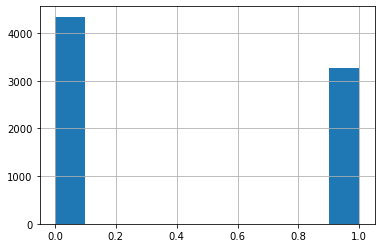

In [9]:
# So no imbalance class problem
train.target.hist()

In [10]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

def lemmatize_text(text): 
    return (' '.join([token.lemma_ for token in nlp(text.lower()) if (token.text not in stop_words) & (not token.is_punct)]).replace('# ', ''))
        

def extract_hashtag(tweet):
    split_tweet = tweet.split('#')
    if len(split_tweet)>1:
        hashtags = [hashtag.split()[0] for hashtag in split_tweet[1:] if len(hashtag)>=1]
        return ' '.join(sorted(hashtags))
    else:
        return 'missing'

In [11]:
# Lemmatize keywords
lemmatized_kw = [lemmatize_text(x) for x in train.keyword.unique()]
lemmatized_dict = dict(zip(train.keyword.unique(), lemmatized_kw))
train['keyword_processed'] = train.keyword.map(lemmatized_dict)
train['keyword_processed'] = train['keyword_processed'].apply(lambda x: ''.join(x.split(' ')))

test['keyword_processed'] = test.keyword.map(lemmatized_dict)
test['keyword_processed'] = test['keyword_processed'].apply(lambda x: ''.join(x.split(' ')))

# Cleanup link in unprocessed text and remove non-ASCII characters
train['text'] = train.text.apply(lambda x: re.sub('http://[aA-zZ0-9\/\.]+|https://[aA-zZ0-9\/\.]+',  'http', x).replace('http http', 'http').lower().encode("ascii", "ignore").decode())
test['text'] = test.text.apply(lambda x:  re.sub('http://[aA-zZ0-9\/\.]+|https://[aA-zZ0-9\/\.]+',  'http', x).replace('http http', 'http').lower().encode("ascii", "ignore").decode())

## Lemmatize main body text
train['text_processed'] = train.text.apply(lambda x: lemmatize_text(x))
test['text_processed'] = test.text.apply(lambda x: lemmatize_text(x))

# Extracting Hashtags
train['hashtags'] = train.text.apply(lambda x: extract_hashtag(x))
test['hashtags'] = test.text.apply(lambda x: extract_hashtag(x))

# Using regex to clean up different links
#train['text_processed'] = train.text_processed.apply(lambda x: re.sub('http://[aA-zZ0-9\/\.]+',  'http', x).replace('http http', 'http'))
#test['text_processed'] = test.text_processed.apply(lambda x:  re.sub('http://[aA-zZ0-9\/\.]+',  'http', x).replace('http http', 'http'))

# Drop duplicates tweets for train test
train = train.drop_duplicates('text_processed').reset_index(drop=True)

In [12]:
train.to_pickle(DATA_DIR/'interim/train.pkl')
test.to_pickle(DATA_DIR/'interim/test.pkl')

Series([], Name: text, dtype: object)

## EDA And Visualization

#### A1. Comparing Keywords Prevalence of Actual Disaster

In [13]:
kw_ohe = pd.get_dummies(train['keyword'],drop_first=True)
train_merged = train.merge(kw_ohe, left_index=True, right_index=True)

In [14]:
kw_val = train_merged.iloc[:, 8:].values
num_disaster = np.array([np.sum(train.target.values * kw_val[:, num]) for num in range(kw_val.shape[1])])

kw_count = train_merged.iloc[:, 8:].sum()
kw_proba = pd.Series(num_disaster/kw_count.values, index=kw_count.index)
kw_proba.sort_values()

body bag           0.000000
aftershock         0.000000
body bags          0.025000
ruin               0.027027
blazing            0.030303
                     ...   
oil spill          0.964286
suicide bombing    0.965517
wreckage           1.000000
debris             1.000000
derailment         1.000000
Length: 221, dtype: float64

In [15]:
# separating Keywords into either groups that has high probability with 0 or 1
low_kw = list(kw_proba.sort_values()[0:50].index)
high_kw = list(kw_proba.sort_values()[-50:].index)
main_kw = low_kw + high_kw
all_kw = kw_proba.index

#### A2. Body Text Prevalence of Actual Disaster

In [16]:
count = CountVectorizer(ngram_range=(1,2), min_df=25)

In [17]:
count = CountVectorizer(ngram_range=(2,2), min_df=10)

In [18]:
vectorized = count.fit_transform(train['text_processed'])
vector = pd.DataFrame(np.c_[vectorized.toarray(), np.array(train.target)], columns = count.get_feature_names()+['target'])

In [19]:
def calc_prevalence(df): 
    features = df.drop('target', axis=1)
    active = np.sum(np.array(features) * train.target.to_numpy().reshape(-1,1), axis=0)
    word_counts = np.sum(np.array(features), axis=0)
    series = pd.Series(active/word_counts, index=features.columns)
    return series.sort_values(ascending=False)


def export_high_prevalence(series, threshold):
    return list(prevalence.index[(prevalence>(1-threshold))]) + list(prevalence.index[(prevalence<threshold)])


In [20]:
prevalence = calc_prevalence(vector)
export_high_prevalence(prevalence, 0.2)

['hundred migrant',
 'california wildfire',
 'plane crash',
 'detonate bomb',
 'possible ebola',
 'project http',
 'provoke outrage',
 'declare disaster',
 'quarantine possible',
 'debris find',
 'crisis famine',
 'crematoria provoke',
 'refugio oil',
 'rescuer search',
 'reunion island',
 'legionnaire disease',
 'saudi security',
 'pkk suicide',
 'devastate saipan',
 'disaster typhoon',
 'find reunion',
 'kill 15',
 'helicopter crash',
 'forest service',
 'food crematoria',
 'flood http',
 'flash flood',
 'northern california',
 'ebola case',
 'famine memory',
 'obama declare',
 'evacuation order',
 'officer wound',
 'old pkk',
 'outrage amid',
 'security site',
 'costlier big',
 'severe thunderstorm',
 'thunderstorm warning',
 'atomic bombing',
 'virgin galactic',
 'big project',
 'site mosque',
 'typhoon devastate',
 'turkey army',
 'bomb turkey',
 'train derailment',
 'amid crisis',
 'train derail',
 'army trench',
 'bomber detonate',
 'bomber kill',
 'suicide bombing',
 'suicide b

In [21]:
train.loc[train.text_processed.str.contains('08')].iloc[1]['text_processed']

'hour august 05 2015 08:02pm red rover zombie apocalypse 2014 http internetradio collegeradi'

In [22]:
train.loc[train.text_processed.str.contains('evacuation')]

,id,keyword,location,text,target,keyword_processed,text_processed,hashtags
2,5,missing,missing,all residents asked to 'shelter in place' are ...,1,miss,resident ask shelter place notify officer evac...,missing
3,6,missing,missing,"13,000 people receive #wildfires evacuation or...",1,miss,"13,000 people receive wildfire evacuation orde...",wildfires
8,14,missing,missing,there's an emergency evacuation happening now ...,1,miss,emergency evacuation happen building street,missing
1243,1952,burning buildings,"Oklahoma City, OK",large fire burning several buildings causing e...,1,burnbuilding,large fire burn building cause evacuation down...,missing
1411,2219,chemical emergency,http://www.amazon.com/dp/B00HR,usa: breaking news: chemical spill/evacuations...,1,chemicalemergency,usa break news chemical spill evacuation red c...,missing
2652,4096,displaced,"Na:tinixw / Hoopa, Berkeley",elem pomo helping the displaced from the rocky...,1,displace,elem pomo help displace rocky fire consider \n...,missing
2951,4541,emergency,"Renfrew, Scotland",@batfanuk we enjoyed the show today. great fun...,0,emergency,@batfanuk enjoy today great fun emergency non ...,missing
2962,4556,emergency plan,Reddit,http #gamergate the end of reddit is coming. i...,0,emergencyplan,http gamergate end reddit come time devise eme...,gamergate
3076,4732,evacuate,"Chevy Chase, MD",the efak would be designed for building occupa...,1,evacuate,efak design build occupant evacuate report eva...,missing
3086,4745,evacuate,London UK,us govt refuses to evacuate 1000s of americans...,1,evacuate,govt refuse evacuate 1000s american yeman http...,abandoned evacuation usa yemen
